In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
import os
import cv2

In [3]:
from torchvision import datasets
from torch.utils.data import Dataset

class LoadDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                self.image_paths.append(image_path)
                self.labels.append(label)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = cv2.imread(image_path)
        # convert to standard RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # convert to numpy array
        image = np.array(image)
        
        # Apply transformations 
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(256, antialias=True),
            transforms.CenterCrop(224),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
        ])
        image = transform(image)
        return image, label

    def __len__(self):
        return len(self.image_paths)

In [4]:
# Create dataset
traindataset = LoadDataset('Images/train')
testdataset = LoadDataset('Images/test')

from torch.utils.data import DataLoader

# Create dataloader
traindataloader = DataLoader(traindataset, batch_size=1, shuffle=True)
testdataloader =  DataLoader(testdataset, batch_size=1, shuffle=False)

## KNN Classifier with deep features

In [5]:
# Load the pre-trained ResNet model
model = models.resnet18(weights="IMAGENET1K_V1")

# Modify the model to remove the last fully connected layer (classifier)
model = torch.nn.Sequential(*(list(model.children())[:-1]))

In [6]:
#function to extract features
def extract_features(image, model):
    with torch.no_grad():
        features = model(image)
    return features.squeeze().numpy()

In [7]:
# Now we run a loop to create a list of train features and its labels
train_features = []
train_labels = []

for batch_idx, (image, label) in enumerate(traindataloader):
    features = extract_features(image, model)
    train_features.append(features)
    label = label.numpy()
    train_labels.append(label)

In [8]:
# Similarly we can do for list of test features
test_features = []
test_labels = []

for batch_idx, (image, label) in enumerate(testdataloader):
    features = extract_features(image, model)
    test_features.append(features)
    label = label.numpy()
    test_labels.append(label)

In [9]:
# convert into numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)
train_labels = train_labels.reshape(-1)

test_features = np.array(test_features)
test_labels = np.array(test_labels)
test_labels = test_labels.reshape(-1)

In [10]:
# Initialize KNN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=3)
# Fit the KNN model
knn.fit(train_features, train_labels)

KNeighborsClassifier(n_neighbors=3)

In [11]:
# let us make predictions using this KNN
preds = knn.predict(test_features)

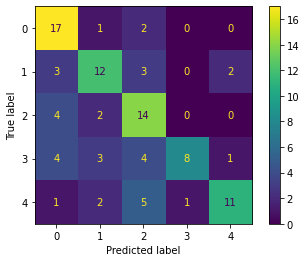

In [12]:
# confusion matrix of the predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

c_matrix = confusion_matrix(test_labels,preds)
disp = ConfusionMatrixDisplay(c_matrix)
disp.plot()

In [13]:
confusion = c_matrix
num_classes = len(c_matrix)
TP = [confusion[i, i] for i in range(num_classes)]
TN = [np.sum(confusion) - np.sum(confusion[i, :]) - np.sum(confusion[:, i]) + confusion[i, i] for i in range(num_classes)]
FP = [np.sum(confusion[:, i]) - confusion[i, i] for i in range(num_classes)]
FN = [np.sum(confusion[i, :]) - confusion[i, i] for i in range(num_classes)]

In [14]:
TP = np.array(TP)
TN = np.array(TN)
FP = np.array(FP)
FN = np.array(FN)
print(TP, TN, FP, FN)

[17 12 14  8 11] [68 72 66 79 77] [12  8 14  1  3] [ 3  8  6 12  9]


In [15]:
#The accuracy of the classes
acc = (TP+TN)/(TP+FP+FN+TN)
print(acc)

[0.85 0.84 0.8  0.87 0.88]


In [16]:
#The sensitivity of the classes
sens = TP/(TP+FN)
print(sens)

[0.85 0.6  0.7  0.4  0.55]


In [17]:
#The specificity of the classes
spec = TN/(TN+FP)
print(spec)

[0.85   0.9    0.825  0.9875 0.9625]


## Fine-tuning

In [18]:
# Some important hyperparameters
EPOCHS = 100
BATCH_SIZE = 4
LEARNING_RATE = 1e-4

In [19]:
from torch.utils.data import Subset
import random

# create seperate traindataloader and validataloader
all_dataset = LoadDataset('Images/train')

# Split training and validation into 120/30
train_indices = random.sample(range(150), 120)
valid_indices = list(set(range(150))- set(train_indices))

# Create dataset
train_dataset = Subset(all_dataset, train_indices)
valid_dataset = Subset(all_dataset, valid_indices)

# Create dataloader
traindataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
validataloader = DataLoader(valid_dataset, batch_size= BATCH_SIZE, shuffle=True)

In [20]:
model = models.resnet18(weights="IMAGENET1K_V1")

# Freeze the model weights
for param in model.parameters():
    param.requires_grad=False

# Add an FC layer at the end to match the number of classes in our dataset
model.fc = torch.nn.Linear(model.fc.in_features, 5)

In [21]:
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)

In [22]:
# Train the model
from datetime import datetime
from torch.autograd import Variable

# # Create directory to save the model states
current_datetime = datetime.now()
date_time_format = current_datetime.strftime("%m-%d_%H-%M")
directory_name = f"weights/run_{date_time_format}"

# Create the directory
os.makedirs(directory_name)
print(f"Model states saved in :{directory_name}")

train_loss = []
train_accu = []
val_loss = []
val_accu = []

for e in range(EPOCHS):
    print("EPOCH: {}/{}".format(e+1, EPOCHS)) 
    running_loss = 0
    correct_pred = 0
    total_pred = 0
    #set the model to train
    model.train()
    epoch_train_loss = []
    epoch_test_accu = []
    for batch_idx, (image, label) in enumerate(traindataloader):
        x = Variable(image)
        y = Variable(label)
        #forward pass
        optimizer.zero_grad()
        pred = model.forward(x)
        #calculate loss
        loss = criterion(pred,y)
        #calculate accuracy
        _, mpred = torch.max(pred,1)
        correct_pred += (mpred == label).sum().item()
        total_pred += label.size(0)
        #backpropagate the loss
        loss.backward()
        optimizer.step()
        #detach
        loss = loss.detach().numpy()
        running_loss += loss      
    train_loss.append(running_loss/len(traindataloader))
    train_accu.append(correct_pred/total_pred)
    print("Train loss: {:.5f}, Train accuracy: {:.5f}".format(
        running_loss/len(traindataloader),correct_pred/total_pred))

    #set the model to test
    model.eval()
    running_loss = 0
    correct_pred = 0
    total_pred = 0
    for batch_idx, (image, label) in enumerate(validataloader):
        x = Variable(image)
        y = Variable(label)
        #forward pass
        pred = model.forward(x)
        #calculate loss
        loss = criterion(pred, y)
        #calculate accuracy
        _, mpred = torch.max(pred,1)
        correct_pred += (mpred == label).sum().item()
        total_pred += label.size(0)
        #detach
        loss = loss.detach().numpy()
        running_loss += loss
    val_loss.append(running_loss/len(validataloader))
    val_accu.append(correct_pred/total_pred)
    print("Validation loss: {:.5f}, Validation accuracy: {:.5f}".format(
        running_loss/len(validataloader),correct_pred/total_pred))
    print('-------------')

    # save model after every 10 epochs
    if e%10==0:
        model_weights_name = f"epoch_{e}.pth"
        model_weights_name = os.path.join(directory_name, model_weights_name)
        torch.save(model.state_dict(), model_weights_name)

Model states saved in :weights/run_11-22_01-52
EPOCH: 1/100
Train loss: 1.64722, Train accuracy: 0.23333
Validation loss: 1.58333, Validation accuracy: 0.33333
-------------
EPOCH: 2/100
Train loss: 1.48075, Train accuracy: 0.40000
Validation loss: 1.38034, Validation accuracy: 0.50000
-------------
EPOCH: 3/100
Train loss: 1.36747, Train accuracy: 0.48333
Validation loss: 1.23362, Validation accuracy: 0.53333
-------------
EPOCH: 4/100
Train loss: 1.28436, Train accuracy: 0.54167
Validation loss: 1.05806, Validation accuracy: 0.66667
-------------
EPOCH: 5/100
Train loss: 1.18818, Train accuracy: 0.65833
Validation loss: 0.98275, Validation accuracy: 0.76667
-------------
EPOCH: 6/100
Train loss: 1.11714, Train accuracy: 0.70000
Validation loss: 0.86644, Validation accuracy: 0.86667
-------------
EPOCH: 7/100
Train loss: 1.03066, Train accuracy: 0.75833
Validation loss: 0.75528, Validation accuracy: 0.86667
-------------
EPOCH: 8/100
Train loss: 1.01863, Train accuracy: 0.77500
Valida

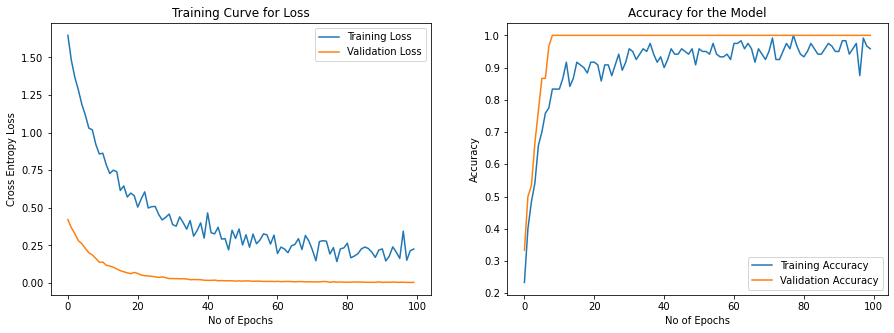

In [23]:
import matplotlib.pyplot as plt

no_epochs = np.arange(len(train_loss))
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Training Curve for Loss')
plt.xlabel('No of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.plot(no_epochs, train_loss, label='Training Loss')
plt.plot(no_epochs, val_loss, label='Validation Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy for the Model')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')
plt.plot(no_epochs, train_accu, label='Training Accuracy')
plt.plot(no_epochs, val_accu, label='Validation Accuracy')
plt.legend()

In [25]:
# Let us now perform inference on test set
model = models.resnet18()
model.fc = torch.nn.Linear(model.fc.in_features, 5)

#load model from epoch
epoch_to_load = 80

# load model weights
model.load_state_dict(torch.load(f"{directory_name}/epoch_{epoch_to_load}.pth"))

<All keys matched successfully>

In [30]:
# lists to save the values
labels_list = []
preds_list = []

# inference on test data
model.eval()
running_loss = 0
correct_pred = 0
total_pred = 0
for batch_idx, (image, label) in enumerate(testdataloader):
    x = Variable(image)
    y = Variable(label)
    pred = model.forward(x)
    #calculate loss 
    loss = criterion(pred, y)
    #calculate accuracy
    _, mpred = torch.max(pred,1)
    correct_pred += (mpred == label).sum().item()
    total_pred += label.size(0)
    #detach
    loss = loss.detach().numpy()
    running_loss += loss
    #saving values
    mpred = mpred.detach().numpy()
    label = label.detach().numpy()
    labels_list.append(label)
    preds_list.append(mpred)

print('Test Accuracy:', correct_pred/total_pred)
print('Test loss:', running_loss/len(testdataloader))

Test Accuracy: 0.96
Test loss: 0.08817716489953455


In [32]:
#create a confusion matrxi
labels_list = np.array(labels_list)
preds_list = np.array(preds_list)

(100, 1) (100, 1)


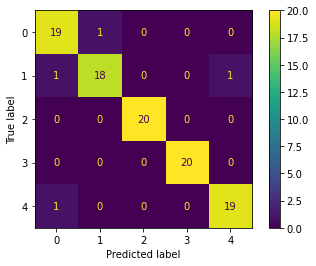

In [33]:
# confusion matrix of the predictions
c_matrix = confusion_matrix(labels_list,preds_list)
disp = ConfusionMatrixDisplay(c_matrix)
disp.plot()